# Decision Tree 

## 1. Import Required Packages

In [2]:
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option("expand_frame_repr", True)
pd.set_option("max_colwidth", None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

# ML FLOW
import mlflow
import subprocess
from pyngrok import ngrok

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

## 2. Import Data

### 2.1 Imbalanced Datasets

In [3]:
X_train = np.load("../notebook/data/Original/X_train.npy")
y_train = np.load("../notebook/data/Original/y_train.npy")
X_val = np.load("../notebook/data/Original/X_val.npy")
y_val = np.load("../notebook/data/Original/y_val.npy")

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((208480, 66), (208480,), (52121, 66), (52121,))

### 2.2 Undersampled Datasets

In [5]:
X_train_under_sample = np.load("../notebook/data/UnderSampling/X_train_undersample.npy")
y_train_under_sample = np.load("../notebook/data/UnderSampling/y_train_undersample.npy")

### 2.3 Oversampled Datasets

In [6]:
X_train_over_sample = np.load("../notebook/data/OverSampling/X_train_oversample.npy")
y_train_over_sample = np.load("../notebook/data/OverSampling/y_train_oversample.npy")

### 2.4 SMOTE Datasets

In [7]:
X_train_smote = np.load("../notebook/data/SMOTE/X_train_smote.npy")
y_train_smote = np.load("../notebook/data/SMOTE/y_train_smote.npy")

In [8]:
# datasets  [("Original", X_train, y_train), ("UnderSampling", X_train_under_sample, y_train_under_sample), ("OverSampling", X_train_over_sample, y_train_over_sample), ("SMOTE", X_train_smote, y_train_smote)]

#### HELPER FUNCTIONS

In [9]:
def run_mlflow_ui():
    proc = subprocess.Popen(["mlflow", "ui"])
    public_url = ngrok.connect(addr = "5000")
    print("MlFlow UI can be accessed at :", public_url)

In [10]:
run_mlflow_ui()

t=2023-06-17T09:26:54+0545 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=C:\\Users\\DELL\\AppData\\Local/ngrok/ngrok.yml legacy_path=C:\\Users\\DELL\\.ngrok2\\ngrok.yml
t=2023-06-17T09:26:54+0545 lvl=eror msg="failed to reconnect session" obj=csess id=670c4b229db9 err="dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-17T09:26:54+0545 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": dial tcp: lookup update.equinox.io: no such host"


MlFlow UI can be accessed at : NgrokTunnel: "https://5a6a-103-10-31-35.ngrok.io" -> "http://localhost:5000"


In [11]:
mlflow.end_run()

In [12]:
def plot_confusion_matrix(true, predicted):
    """
    Generate the confusion matrix and classification report
    """
    cm = confusion_matrix(true, predicted)
    cr = classification_report(true, predicted)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3'],
                                             index=['Actual:1','Actual:2','Actual:3'])
    # confusion matrix in heatmap
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print(cr) 
    f1_micro = f1_score(true, predicted, average='micro')
    return f1_micro

In [13]:
def evaluate_model(model):
    
    print("Evaluating Model")
    
    # Make predictions
    y_train_pred = model.predict(X_train_smote)
    y_val_pred = model.predict(X_val)
    
    # Calculate micro averaged f1-score
    f1_micro_train = f1_score(y_train_smote, y_train_pred, average='micro')
    f1_micro_val = f1_score(y_val, y_val_pred, average='micro')
    
    print("Finished Evaluating Model")
    
    return f1_micro_train, f1_micro_val, y_train_pred, y_val_pred

In [14]:
def grid_search_cv(estimator, X_train, y_train, param_grid):
    
    print("Performing GridSearchCv")
    
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print("Finished GridSearchCv")
    return best_params

In [15]:
def train_model(estimator,X, y, best_params, estimator_name, dataset_type):
    
    print("Training Model")
    
    best_estimator = estimator.set_params(**best_params)
    
    # start time
    start_time = time.time()
    
    best_estimator.fit(X, y)
    
    # end time
    end_time = time.time()
    
    duration = np.round(end_time-start_time, 2)
    
    f1_micro_train, f1_micro_val, _ , y_val_pred = evaluate_model(best_estimator)
    
    log_results(best_params, best_estimator, estimator_name, f1_micro_train, f1_micro_val, dataset_type, duration)
    
    print("Successfull")
    
    return y_val_pred

In [16]:
def log_results(best_params, estimator, estimator_name, f1_micro_train, f1_micro_val, dataset_type, duration):
    
    print("Logging Results")
    with mlflow.start_run(run_name=f"{estimator_name}{dataset_type}"):
        mlflow.log_metric("f1_micro_train", f1_micro_train)
        mlflow.log_metric("f1_micro_val", f1_micro_val)
        mlflow.log_metric("Train Duration", duration)
  
        # Set best params
        for param_name, param_value in best_params.items():
            mlflow.log_param(param_name, param_value) 
    print("Finished Logging Results")

In [17]:
def decision_tree_model_fitting(X_train, y_train, dataset_type, grid_params):
    # Instantiating the model
    estimator = DecisionTreeClassifier()

    decision_tree_params = grid_params
    estimator_name = "decision_tree"

    best_params = grid_search_cv(estimator,X_train, y_train, decision_tree_params)
    print(f"Best Params for {dataset_type}: {best_params}")

    y_val_pred = train_model(estimator, X_train, y_train, best_params, estimator_name, dataset_type)

    f1_micro_score = plot_confusion_matrix(y_val, y_val_pred)

    print(f"F1 Micro Averaged Score = {f1_micro_score}")
    return best_params

# Decision Tree Classifier

## Experiment 1: Tuning `max_depth` parameter

### `Decision Tree Classifier on Imabalanced Dataset`

In [13]:
max_depth_params = {
       "max_depth": [5, 10, 15, 20, 30], 
    }

Performing GridSearchCv
Finished GridSearchCv
Best Params for imbalanced_DecisionTree: {'max_depth': 15}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


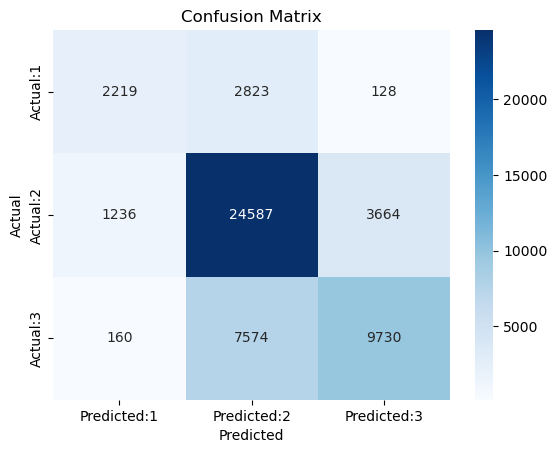

              precision    recall  f1-score   support

           1       0.61      0.43      0.51      5170
           2       0.70      0.83      0.76     29487
           3       0.72      0.56      0.63     17464

    accuracy                           0.70     52121
   macro avg       0.68      0.61      0.63     52121
weighted avg       0.70      0.70      0.69     52121

F1 Micro Averaged Score = 0.7009842481917078


In [14]:
imbalanced_best_params = decision_tree_model_fitting(X_train, y_train, "imbalanced_DecisionTree", grid_params=max_depth_params)

### `Decision Tree Classifier on Undersampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for UndersampledDecisionTree: {'max_depth': 15}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


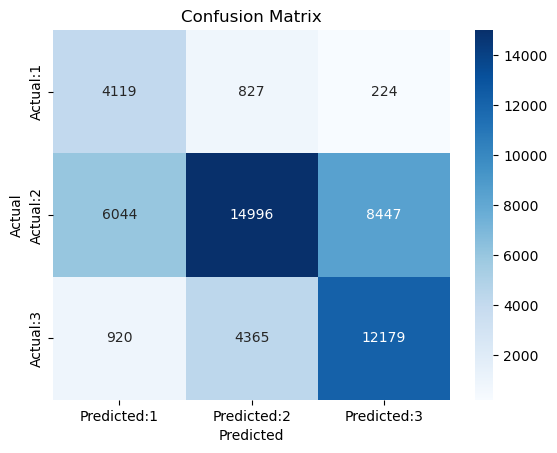

              precision    recall  f1-score   support

           1       0.37      0.80      0.51      5170
           2       0.74      0.51      0.60     29487
           3       0.58      0.70      0.64     17464

    accuracy                           0.60     52121
   macro avg       0.57      0.67      0.58     52121
weighted avg       0.65      0.60      0.60     52121

F1 Micro Averaged Score = 0.6004105830663264


In [18]:
undersampled_best_params = decision_tree_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledDecisionTree", grid_params=max_depth_params)

### `Decision Tree Classifier on Oversampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for OversampledDecisionTree: {'max_depth': 30}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


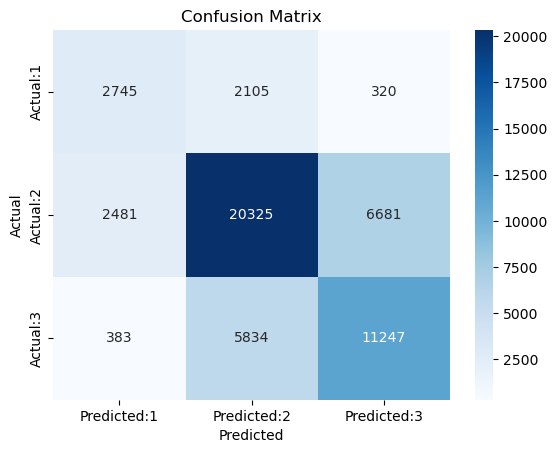

              precision    recall  f1-score   support

           1       0.49      0.53      0.51      5170
           2       0.72      0.69      0.70     29487
           3       0.62      0.64      0.63     17464

    accuracy                           0.66     52121
   macro avg       0.61      0.62      0.61     52121
weighted avg       0.66      0.66      0.66     52121

F1 Micro Averaged Score = 0.6584102377160838


t=2023-06-17T08:22:35+0545 lvl=eror msg="heartbeat timeout, terminating session" obj=csess id=5ccdc5350cc7 clientid=08f8316b4c5337b172912d043a1c175a
t=2023-06-17T08:22:35+0545 lvl=eror msg="session closed, starting reconnect loop" obj=csess id=66c818c6c77f err="session closed"
t=2023-06-17T08:22:45+0545 lvl=eror msg="failed to reconnect session" obj=csess id=66c818c6c77f err="context deadline exceeded"
t=2023-06-17T08:22:59+0545 lvl=eror msg="failed to reconnect session" obj=csess id=66c818c6c77f err="context deadline exceeded"
t=2023-06-17T08:23:09+0545 lvl=eror msg="failed to reconnect session" obj=csess id=66c818c6c77f err="context deadline exceeded"


In [19]:
oversampled_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=max_depth_params)

### `Decision Tree Classifier on SMOTE Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for SMOTEDecisionTree: {'max_depth': 20}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


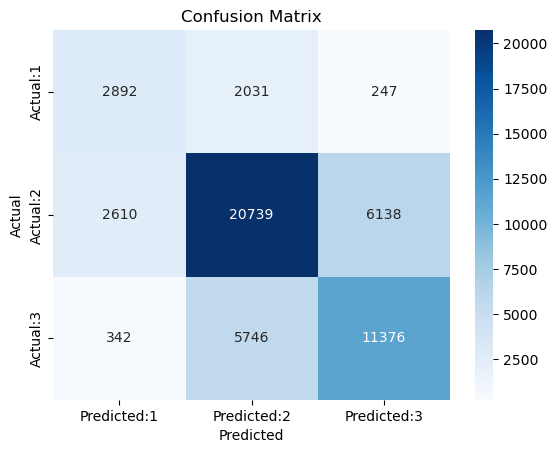

              precision    recall  f1-score   support

           1       0.49      0.56      0.53      5170
           2       0.73      0.70      0.72     29487
           3       0.64      0.65      0.65     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.64      0.63     52121
weighted avg       0.68      0.67      0.67     52121

F1 Micro Averaged Score = 0.671648663686422


In [20]:
smote_best_params = decision_tree_model_fitting(X_train_smote, y_train_smote, "SMOTEDecisionTree", grid_params=max_depth_params)

### `Result Analysis`
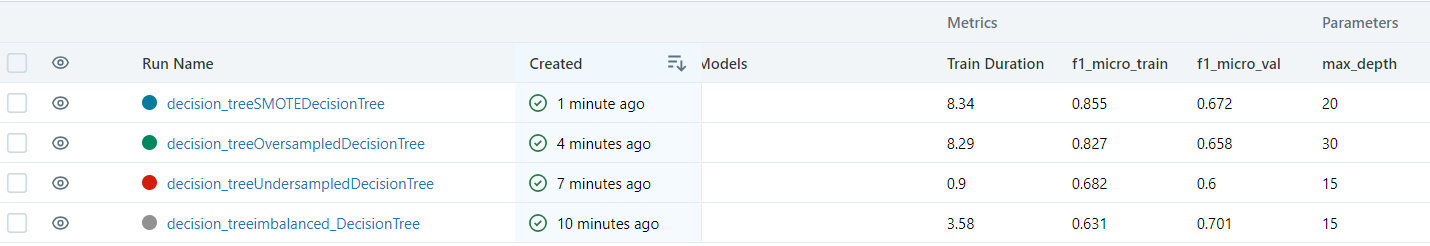

Here, we can see that decision tree classifier is sufferring from overfitting problem for `SMOTE, Oversampled and Imbalanced` Datasets whereas it seems to be working quite good on `undersampled` dataset.

### Experiment 2: Tuning `min_samples_split`

In [21]:
min_samples_split_param = {
    "min_samples_split": np.arange(10, 15)
}

### `Decision Tree Classifier on Imbalanced Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for imbalanced_DecisionTree: {'min_samples_split': 14}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


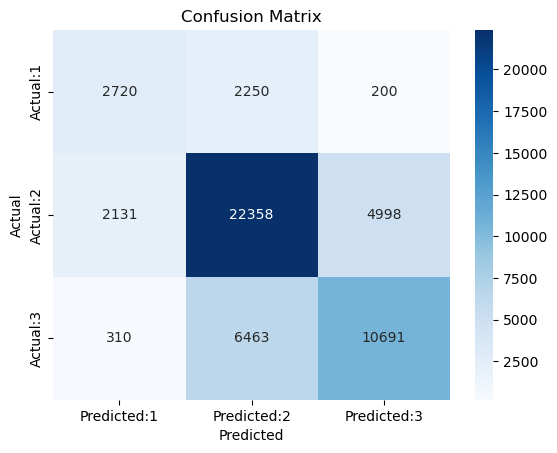

              precision    recall  f1-score   support

           1       0.53      0.53      0.53      5170
           2       0.72      0.76      0.74     29487
           3       0.67      0.61      0.64     17464

    accuracy                           0.69     52121
   macro avg       0.64      0.63      0.64     52121
weighted avg       0.68      0.69      0.68     52121

F1 Micro Averaged Score = 0.6862684906275781


In [22]:
imbalanced_best_params = decision_tree_model_fitting(X_train, y_train, "imbalanced_DecisionTree", grid_params=min_samples_split_param)

### `Decision Tree Classifier on Undersampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for UndersampledDecisionTree: {'min_samples_split': 14}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


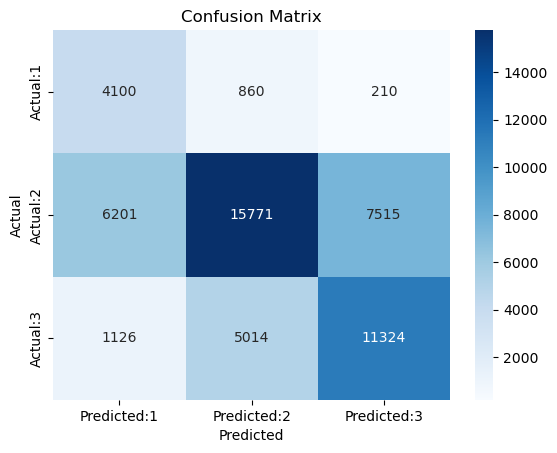

              precision    recall  f1-score   support

           1       0.36      0.79      0.49      5170
           2       0.73      0.53      0.62     29487
           3       0.59      0.65      0.62     17464

    accuracy                           0.60     52121
   macro avg       0.56      0.66      0.58     52121
weighted avg       0.65      0.60      0.61     52121

F1 Micro Averaged Score = 0.5985111567314518


In [23]:
undersampled_best_params = decision_tree_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledDecisionTree", grid_params=min_samples_split_param)

### `Decision Tree Classifier on Oversampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for OversampledDecisionTree: {'min_samples_split': 10}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


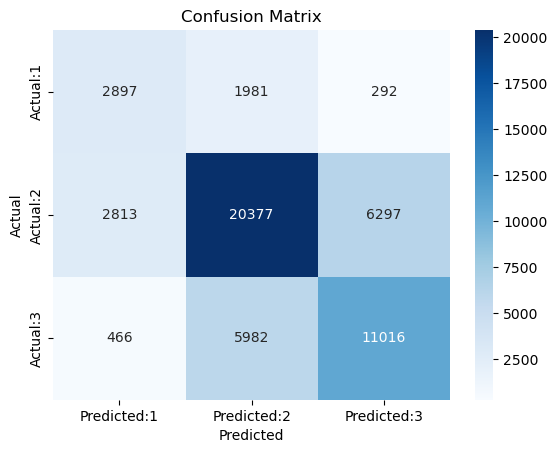

              precision    recall  f1-score   support

           1       0.47      0.56      0.51      5170
           2       0.72      0.69      0.70     29487
           3       0.63      0.63      0.63     17464

    accuracy                           0.66     52121
   macro avg       0.60      0.63      0.61     52121
weighted avg       0.66      0.66      0.66     52121

F1 Micro Averaged Score = 0.657892212352027


In [24]:
oversampled_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=min_samples_split_param)

### `Decision Tree Classifier on SMOTE Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for SMOTEDecisionTree: {'min_samples_split': 14}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


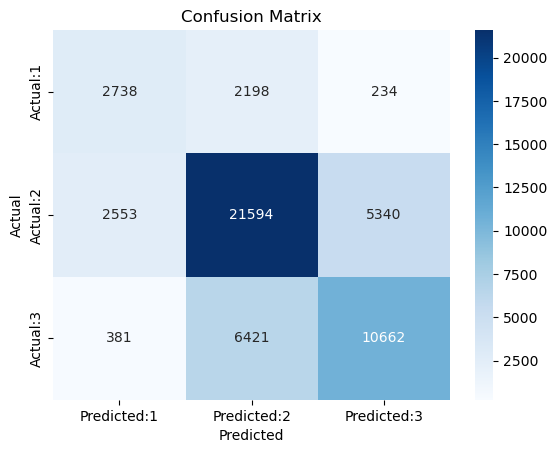

              precision    recall  f1-score   support

           1       0.48      0.53      0.51      5170
           2       0.71      0.73      0.72     29487
           3       0.66      0.61      0.63     17464

    accuracy                           0.67     52121
   macro avg       0.62      0.62      0.62     52121
weighted avg       0.67      0.67      0.67     52121

F1 Micro Averaged Score = 0.6713992440666909


In [25]:
smote_best_params = decision_tree_model_fitting(X_train_smote, y_train_smote, "SMOTEDecisionTree",grid_params=min_samples_split_param)

### `Result Analysis`
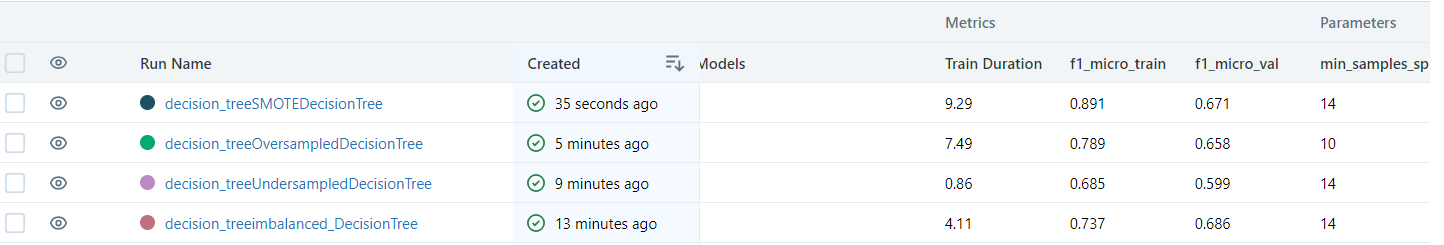

We can see that our model is still sufferring from overfitting problem. The algorithm have higher f1 score on
dataset created with `SMOTE` technique as seen before

### Experiement 2: Performing` Cost Complexity Pruning`

In [26]:
ccp_alpha_param_grid = {
    'ccp_alpha': [0.0, 0.01, 0.1, 0.5, 1.0]
}

### `Decision Tree Classifier on Undersampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for UndersampledDecisionTree: {'ccp_alpha': 0.0}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


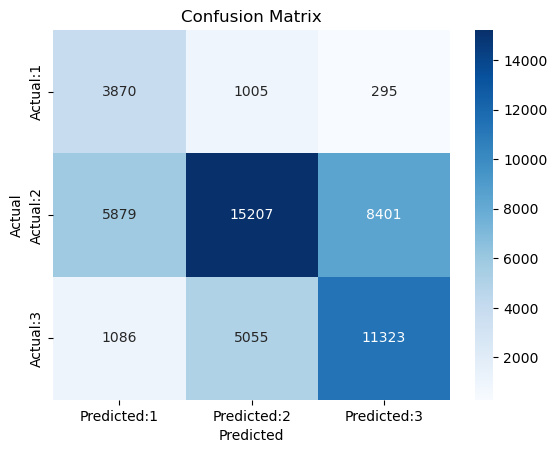

              precision    recall  f1-score   support

           1       0.36      0.75      0.48      5170
           2       0.72      0.52      0.60     29487
           3       0.57      0.65      0.60     17464

    accuracy                           0.58     52121
   macro avg       0.55      0.64      0.56     52121
weighted avg       0.63      0.58      0.59     52121

F1 Micro Averaged Score = 0.5832581876786708


In [27]:
undersampled_best_params = decision_tree_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledDecisionTree", grid_params=ccp_alpha_param_grid)

### `Decision Tree Classifier on Oversampled Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for OversampledDecisionTree: {'ccp_alpha': 0.0}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


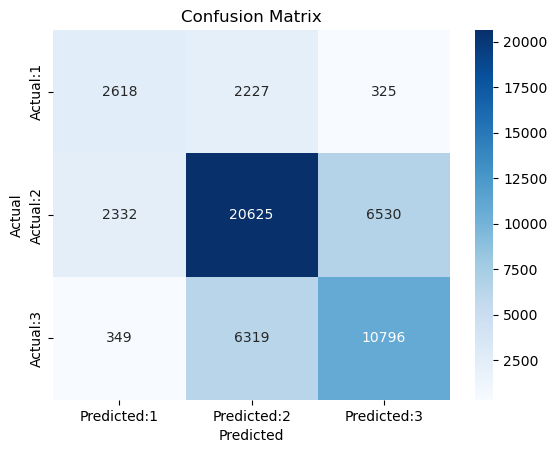

              precision    recall  f1-score   support

           1       0.49      0.51      0.50      5170
           2       0.71      0.70      0.70     29487
           3       0.61      0.62      0.61     17464

    accuracy                           0.65     52121
   macro avg       0.60      0.61      0.61     52121
weighted avg       0.65      0.65      0.65     52121

F1 Micro Averaged Score = 0.6530764950787591


In [28]:
oversampled_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=ccp_alpha_param_grid)

### `Decision Tree Classifier on SMOTE Dataset`

Performing GridSearchCv
Finished GridSearchCv
Best Params for SMOTEDecisionTree: {'ccp_alpha': 0.0}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


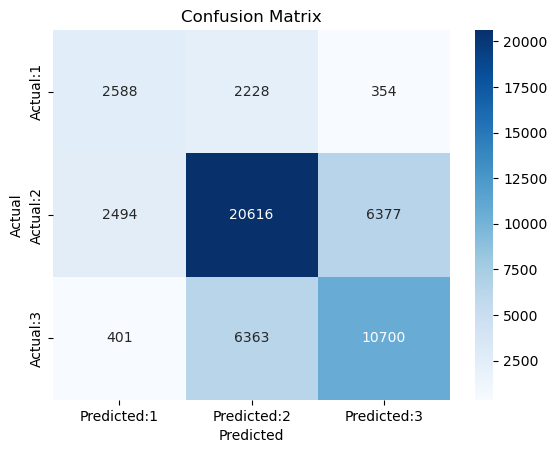

              precision    recall  f1-score   support

           1       0.47      0.50      0.49      5170
           2       0.71      0.70      0.70     29487
           3       0.61      0.61      0.61     17464

    accuracy                           0.65     52121
   macro avg       0.60      0.60      0.60     52121
weighted avg       0.65      0.65      0.65     52121

F1 Micro Averaged Score = 0.6504863682584755


In [29]:
smote_best_params = decision_tree_model_fitting(X_train_smote, y_train_smote, "SMOTEDecisionTree",grid_params=ccp_alpha_param_grid)

### `Result Analysis`
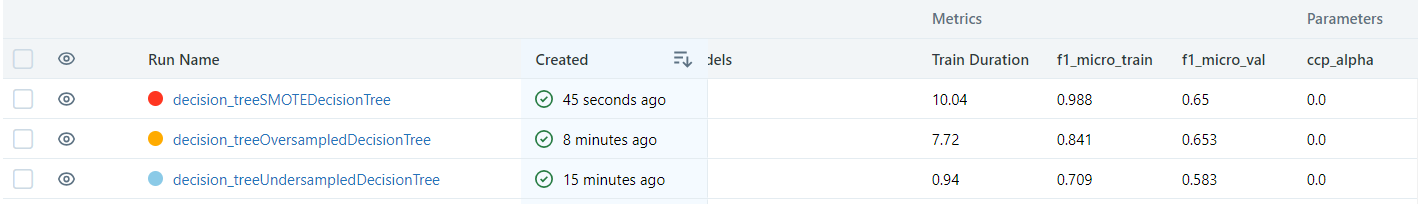

We can see that our model seems to have more overfitting problem.

## Experiment 3: Tuning `class_weight` and `max_features param`

In [18]:
param_grid = {
    "class_weight": ["balanced", None],
    "max_features": [None, "sqrt", "log2"]
}

Performing GridSearchCv
Finished GridSearchCv
Best Params for UndersampledDecisionTree: {'class_weight': 'balanced', 'max_features': None}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


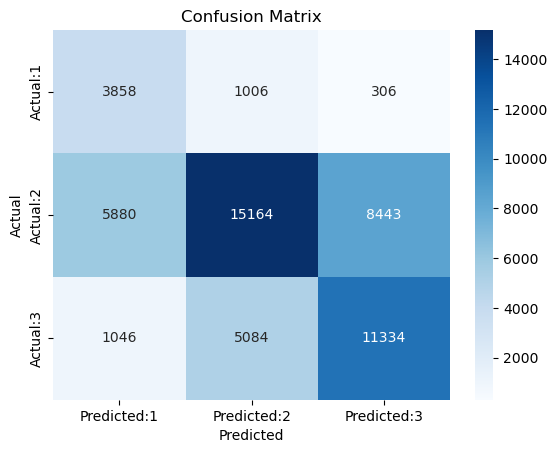

              precision    recall  f1-score   support

           1       0.36      0.75      0.48      5170
           2       0.71      0.51      0.60     29487
           3       0.56      0.65      0.60     17464

    accuracy                           0.58     52121
   macro avg       0.55      0.64      0.56     52121
weighted avg       0.63      0.58      0.59     52121

F1 Micro Averaged Score = 0.5824139981965043


In [19]:
# Undersampled Dataset
undersampled_best_params = decision_tree_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledDecisionTree", grid_params=param_grid)

Performing GridSearchCv
Finished GridSearchCv
Best Params for OversampledDecisionTree: {'class_weight': 'balanced', 'max_features': None}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


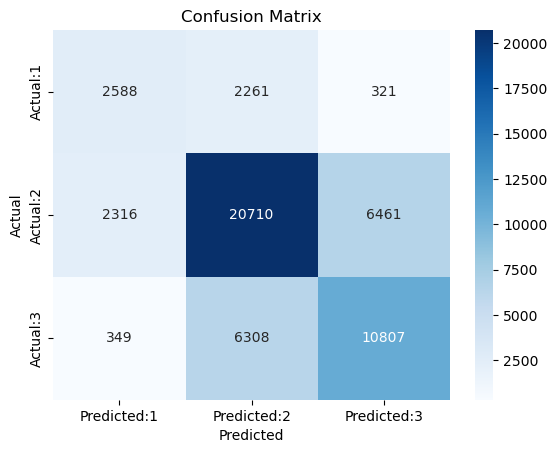

              precision    recall  f1-score   support

           1       0.49      0.50      0.50      5170
           2       0.71      0.70      0.70     29487
           3       0.61      0.62      0.62     17464

    accuracy                           0.65     52121
   macro avg       0.60      0.61      0.61     52121
weighted avg       0.65      0.65      0.65     52121

F1 Micro Averaged Score = 0.6543427793020088


In [20]:
# Oversampled Dataset
oversampled_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=param_grid)

Performing GridSearchCv
Finished GridSearchCv
Best Params for SMOTEDecisionTree: {'class_weight': None, 'max_features': None}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


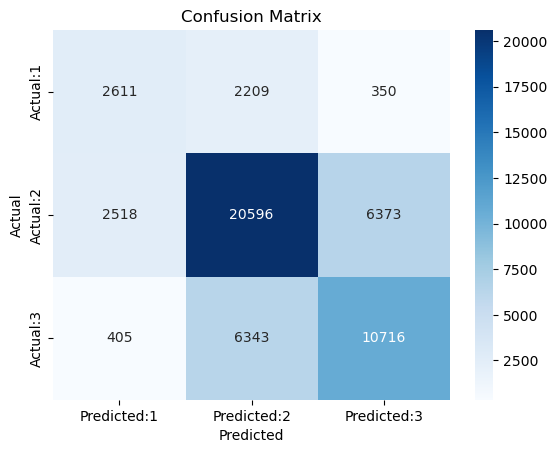

              precision    recall  f1-score   support

           1       0.47      0.51      0.49      5170
           2       0.71      0.70      0.70     29487
           3       0.61      0.61      0.61     17464

    accuracy                           0.65     52121
   macro avg       0.60      0.61      0.60     52121
weighted avg       0.65      0.65      0.65     52121

F1 Micro Averaged Score = 0.6508509046257747


In [21]:
# SMOTE Dataset
smote_best_params = decision_tree_model_fitting(X_train_smote, y_train_smote, "SMOTEDecisionTree",grid_params=param_grid)

### `Result Analysis`
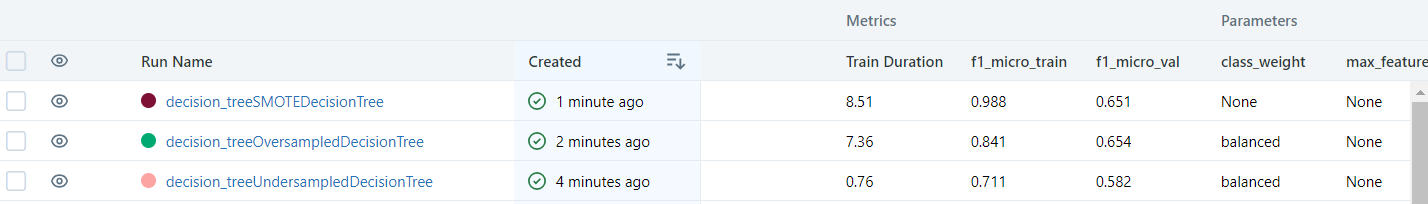

We can see that our model is still suffering from overfitting problem.

## Experiment 4
In this section, we will now combine all the hyperparameters (`max_depth`, `min_samples_split`) and train the model 

In [25]:
param_space = {
            "max_depth": np.arange(15, 20),
            "min_samples_split": np.arange(10, 14),
}

Performing GridSearchCv
Finished GridSearchCv
Best Params for UndersampledDecisionTree: {'max_depth': 15, 'min_samples_split': 12}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


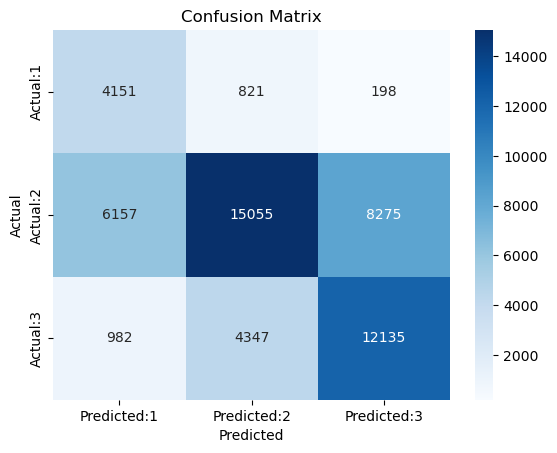

              precision    recall  f1-score   support

           1       0.37      0.80      0.50      5170
           2       0.74      0.51      0.61     29487
           3       0.59      0.69      0.64     17464

    accuracy                           0.60     52121
   macro avg       0.57      0.67      0.58     52121
weighted avg       0.65      0.60      0.61     52121

F1 Micro Averaged Score = 0.601312330922277


In [26]:
# Undersampled Dataset
undersampled_best_params = decision_tree_model_fitting(X_train_under_sample, y_train_under_sample, "UndersampledDecisionTree", grid_params=param_space)

Performing GridSearchCv
Finished GridSearchCv
Best Params for OversampledDecisionTree: {'max_depth': 19, 'min_samples_split': 10}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


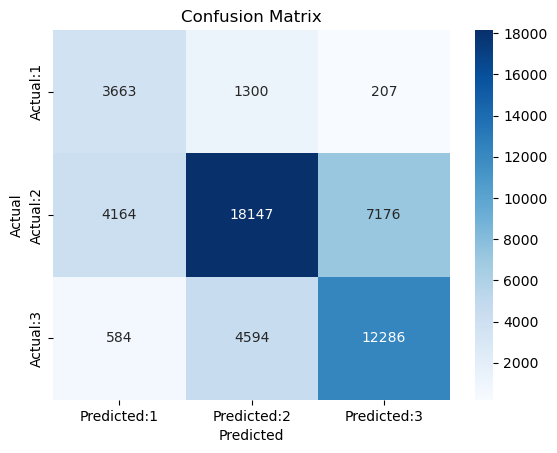

              precision    recall  f1-score   support

           1       0.44      0.71      0.54      5170
           2       0.75      0.62      0.68     29487
           3       0.62      0.70      0.66     17464

    accuracy                           0.65     52121
   macro avg       0.60      0.68      0.63     52121
weighted avg       0.68      0.65      0.66     52121

F1 Micro Averaged Score = 0.6541701041806566


In [27]:
# Oversampled Dataset
oversampled_best_params = decision_tree_model_fitting(X_train_over_sample, y_train_over_sample, "OversampledDecisionTree", grid_params=param_space)

Performing GridSearchCv
Finished GridSearchCv
Best Params for SMOTEDecisionTree: {'max_depth': 19, 'min_samples_split': 11}
Training Model
Evaluating Model
Finished Evaluating Model
Logging Results
Finished Logging Results
Successfull


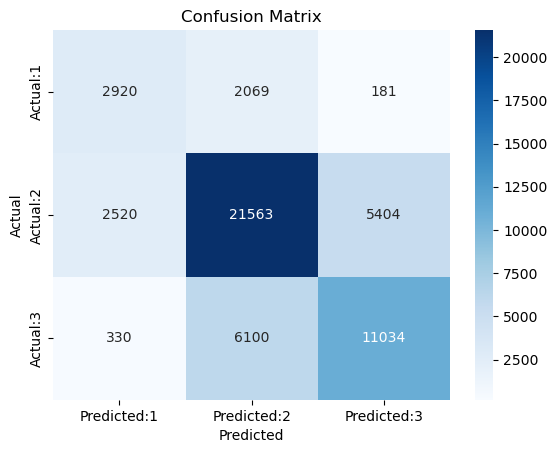

              precision    recall  f1-score   support

           1       0.51      0.56      0.53      5170
           2       0.73      0.73      0.73     29487
           3       0.66      0.63      0.65     17464

    accuracy                           0.68     52121
   macro avg       0.63      0.64      0.64     52121
weighted avg       0.68      0.68      0.68     52121

F1 Micro Averaged Score = 0.6814335872297155


In [28]:
# SMOTE Dataset
smote_best_params = decision_tree_model_fitting(X_train_smote, y_train_smote, "SMOTEDecisionTree",grid_params=param_space)

### `Result Analysis` 
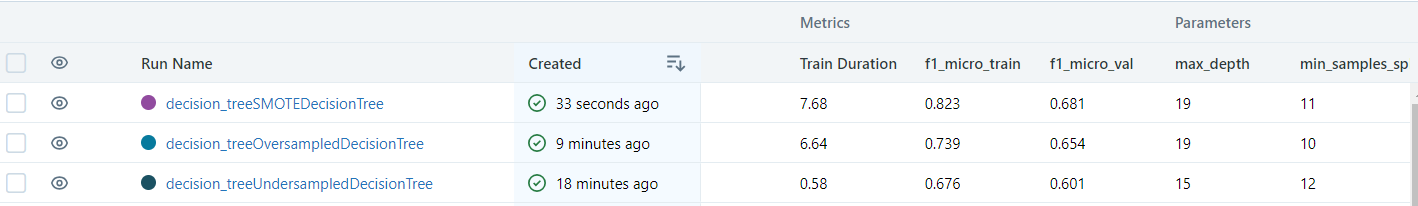

We are still not able to reduce overfitting problem.

### Let's perform Hyperparameter Tuning with our Random Forest Classifier

In [ ]:
def random_forest_with_tuning(X_train, y_train):

    # Define the hyperparameter space
    param_space = {
        "n_estimators": np.arange(100, 1001, 100),
        "max_depth": [None] + list(np.arange(5, 31, 5)),
        "min_samples_split": np.arange(2, 11),
        "min_samples_leaf": np.arange(1, 6),
        "max_features": [None, "sqrt", "log2"]
    }
    
    # Create the random forest classifier with default hyperparameters
    clf = RandomForestClassifier(random_state=42)

    # Create the random search object
    random_search = RandomizedSearchCV(clf, param_space, cv=5, n_iter=100, n_jobs=-1)
    
    # start time
    start_time = time.time()

    # Fit the random search object to the training data
    random_search.fit(X_train, y_train)

    # end time
    end_time = time.time()
    
    time_ellapsed = np.round(end_time - start_time, 2)
    
    # Print the best hyperparameters
    print("Best hyperparameters:", random_search.best_params_)

    # Evaluate the model with the best hyperparameters on the validation set
    clf_best = random_search.best_estimator_
    y_val_pred = clf_best.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average="micro")
    
    # Evaluate Train and Validation dataset
    model_train_f1 = evaluate_model(y_train, y_train_pred)
    model_val_f1 = evaluate_model(y_val, y_val_pred, test=True)

    print("Model Performance for Training Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_train_f1))
    print("--------------------------------------")

    print("Model Performance for Validation Set")
    print("F1 Micro-Averaged Score: {:.4f}".format(model_val_f1))

    results = pd.DataFrame([["DecisionTreeClassifier_ccp", model_train_f1, model_val_f1, time_ellapsed, random_search.best_params_]], columns=['Model Name', 'Train Micro Averaged F1-Score', 'Val Micro Averaged F1-Score', 'Time', 'Parameter']).sort_values(by=["Val Micro Averaged F1-Score"],ascending=False)
    write_results(results)
    return results

**Performing Tuning with Random Forest required us lots of time!**

In [ ]:
# random_forest_with_tuning(X_train, y_train)